# Analysis of Intel Stock Prices

### Alan Elbert

##  Introduction 

Predicting a stocks price is a multibillion dollar industry, with numerous hedgefunds investing massive sums of money in order to determine what will happen to a stock's price. Thousands, if not millions of factors affect the price of a stock, ranging from the overall performance of the economy, public sentiment, commodity prices, geopolitical events, and much more.

Intel is one of but many companies traders all over the world buy and sell on a daily basis. For those unaware, Intel is a chip manufacturing company, selling chips that are used in computers worldwide, perhaps even in the machine this tutorial is being read on.

The overall objective of this tutorial will be to analyze the prices of Intel stock, specifically in comparison to commodity price indices and the performance of other stocks related to Intel, mainly its competitors and companies that Intel does business with (Suppliers and Customers of Intel). Although this will come no where near the scale of analysis done at larger firms with more resources, it will still reveal a few interesting trends that would be invaluable a budding trader interested in trading Intel stock, although we might gain a few bonus insights into the industry as a whole.



### Required Libraries

You will need the following libraries and all their dependencies for this project

1. Pandas
2. Numpy
3. ScikitLearn
4. Statsmodels
5. Matplotlib
6. Datetime
7. Scipy
8. Requests
9. json


In [1245]:

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
from scipy import stats
import statsmodels.api as sm
from datetime import date
import os.path
import json
from datetime import date
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Warnings about the future kept clogging up the output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Acquisition and Processing

This is the data acquisition and wrangling phase of the data science lifecycle. To make it easier to follow along, we are going to combine both parts into one for every source of data

For our analysis today, we will be getting two types of data, stock and commodity price data. Getting each will require the use of different libraries and different techniques to wrangle for use later.

## 1a Stock Data

### Data Acquisition

We want to compare Intel's stock prices to various other companies in the industry related to Intel. We are mainly going to focus on four different kinds of companies, Intel (INTC) itself, Intel's suppliers, Intel's customers, and Intel's competitors. We will only use data from after 2001, because in 2000 there was a massive stock crash involving numerous tech comapanies (the dot com bubble), which for us represents a massive outlier.

If you read this massive financial statement, linked below, several insights can be found about what comapnies we should focus on for our analysis:

https://www.intc.com/filings-reports/annual-reports/content/0000050863-22-000007/0000050863-22-000007.pdf

Firstly, Intel's three largest customers, Dell (DELL), Lenovo (LNVGF), and HP Inc (HPE) , accounted for 43% of Intel's revenue. However, this report unfortunately does not include any mention of smaller customers, but for the purposes of this tutorial, especially when they take up such a large portion of Intel's revenue, they will be enough.

As for suppliers, a list of Intel's top suppliers can be found here:

https://www.intc.com/news-events/press-releases/detail/1455/intel-2020-supplier-continuous-quality-improvement-awards

For the purposes of this analysis, we will be focusing on Intel's top suppliers, namely those who received the SCQI award. As such, they are 

* Applied Materials, Inc (AMAT)
* Lam Research Corporation (LRCX)
* Securitas Security Services USA, Inc (SECU-B.ST)
* Siltronic AG (WAF.DE)
* Taiwan Semiconductor Manufacturing Company, Limited (TSM)
* Tokyo Electron Limited (TOELY)

Additionally, looking at the page, you will notice that these suppliers represent diverse and varied industries, randing from silicon wafers to solder paste, and will hopefully paint the best possible picture of the performance of Intel's suppliers.

Finally, as for the main competitors, a list of such companies can be found here, from Investopedia, which are namely:

* AMD (AMD)
* IBM (IBM)
* NVIDIA (NVDA)
* Samsung (SMSN.IL)

Hopefully, by analyzing the stocks of all these companies related to Intel, we will find some interesting relationships that will allow us to somewhat predict the its stock price.

In order to do this, we will use Yahoo's Finance API along with requests and json libraries in order to request the information we need directly from Yahoo's database through the Spark API endpoint. More information on how to use the Finance API with the requests library can be found in the links below:

https://www.yahoofinanceapi.com/tutorial
https://www.yahoofinanceapi.com/


Another way to get Yahoo's finance data is to go directly to Yahoo's site and download the data as a .csv file. This is somewhat tedious however, and does not scale well if you want to analyze additional companies. In this tutorial, we will do both. For Intel's stock data, we will download it directly in order to demonstrate the latter method using the link below, but for every other companies' stock data we will go the requests route.

https://finance.yahoo.com/quote/intc/history/

(Use the download link under the apply button)

In [1246]:

# This method returns a JSON containing data for the company(s) requested
def get_historical_data(symbols):

    # We want to use the spark endpoint (Historical data for the yahoo finance API)
    url = "https://yfapi.net/v8/finance/spark"

    # Automatically generates the request we need
    querystring = {"symbols":symbols, "range":"21y", "interval":"1mo"}

    # This is the key associated with my personal free account. If this does not work for some reason, you can make your own account using the links above, and use your own key
    headers = {
        'x-api-key': "PKGDrT01fX36RI0yCCEbfaPqLfqvToj71o3reBkp"
        }

    # Requesting the necessary info and returning it as a JSON
    response = requests.request("GET", url, headers=headers, params=querystring)
    return response.json()



# Putting all the companies into their respective catergories
customers = ['DELL','LNVGF','HPE']

# I omitted LCRX as there was a strange error downloading the json file
suppliers = ['AMAT', 'SECU-B.ST','WAF.DE','TSM','TOELY']
competitors = ['AMD','IBM','NVDA','SMSN.IL']

everyone = customers + suppliers + competitors


# The free API has limited requests per day. So, if the JSON already exists, there is no point in wasting precious API calls. So, as soon as we get the JSON we save it locally
# Another issue I found was that although the API allows you to request data for up to 10 companies at a time, there is somewhat of a cap on JSON size, which caused missing data
# To alleviate this, we can just request the data for companies individually
for n in everyone:

    if not os.path.exists(n + ".json"):
        print("Downloading: " + n)
        data = get_historical_data(n)
        with open(n + ".json", 'w') as f:
            json.dump(data, f)





Now that we have gotten all the data downloaded from Yahoo's API in .json format, the next step is to load in Intel's data. This was manually downloaded from the website (link above) and transfered to the tutorial folder. Once it is locally available, loading it is as simple as using pandas' .load_csv() function, and turned into a Dataframe, which is pretty much a glorified array containing lots of data, which pandas provides handy functions to manipulate. If you are unfamiliar with pandas, the link below is useful:

https://pandas.pydata.org/docs/user_guide/10min.html

In [1247]:
# A mirror to the dataset can be found at the link below:
# https://cdn.discordapp.com/attachments/539604374826254378/975548245902250004/INTC2.csv

intcdf = pd.read_csv('INTC.csv')
intcdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-01,28.570000,31.360001,25.559999,27.620001,16.863897,976795600
1,2002-06-01,27.430000,28.200001,17.450001,18.270000,11.163094,1334010600
2,2002-07-01,18.350000,19.879999,16.260000,18.790001,11.480818,1507029200
3,2002-08-01,18.719999,19.670000,15.820000,16.670000,10.185485,1182004600
4,2002-09-01,16.469999,17.040001,13.670000,13.890000,8.497054,1253168200


### Data Processing

Looking at the dataframe, we have seven columns. Open, High, Low, Close, Adj Close, and Volume. For the purposes of this tutorial, we are ultimately interested in discovering what factors make Intel's stock go up or down in any given month, so the columns we are really interested in are the Date, Open, and Close columns.

There is a glaring issue that comes up when you examine stock prices across years. A drop from 100$ to 98$ is not as significant for investors as say a drop from 10$ to 8$. If you invested 100$ in the former, you would only lose 2$, but investing in the latter would lose you 20$. All of these stocks go through large swings in their prices over the past twenty years, so just computing the change in dollars between the open and close for every month would simply be misleading and innaccurate. In order to enable us to compare changes in prices across varying price levels, we are going to compute the percent change instead.

For the Intel dataframe, this process is quite simple, we can just subtract the open price column from the close price column, divide it by the open price column, and then multiply by 100 to get our percent change.

In [1248]:
intcdf["percent_change"] = ((intcdf["Close"] - intcdf["Open"]) / intcdf["Open"]) * 100.0
intcdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume,percent_change
0,2002-05-01,28.570000,31.360001,25.559999,27.620001,16.863897,976795600,-3.325163
1,2002-06-01,27.430000,28.200001,17.450001,18.270000,11.163094,1334010600,-33.394094
2,2002-07-01,18.350000,19.879999,16.260000,18.790001,11.480818,1507029200,2.397826
3,2002-08-01,18.719999,19.670000,15.820000,16.670000,10.185485,1182004600,-10.950850
4,2002-09-01,16.469999,17.040001,13.670000,13.890000,8.497054,1253168200,-15.664840


Additionally, now that we have computed the percent change, the other columns are quite useless for our analysis, and keeping them will only cause bloat and confusion, so we will drop them using the following line of code.

In [1249]:
intcdf.drop(intcdf.columns.difference(['Date', 'percent_change']), 1, inplace=True)

# Also taking the oppurtunity to update the Date column to a format that can be directly compared
# The String is already in isoformat so conversion is quite simple
intcdf['Date'] = [ date.fromisoformat(ts) for ts in intcdf['Date'] ]

intcdf.head()

,Date,percent_change
0,2002-05-01,-3.325163
1,2002-06-01,-33.394094
2,2002-07-01,2.397826
3,2002-08-01,-10.950850
4,2002-09-01,-15.664840


We have now processed the Intel data into a format that we can use for further analysis. Now the tricky part begins, dealing with the JSON data. Unlike a .csv which is easily readable by pandas, a json is not. Although pandas does have a read_json function, looking at the output below for AMD.json, for example, it simply is not formatted correctly.

In [1250]:
amd_t = pd.read_json('AMD.json', orient='index')
amd_t.head()

,symbol,timestamp,dataGranularity,close,end,start,previousClose,chartPreviousClose
AMD,AMD,"[991368000, 993960000, 996638400, 999316800, 1...",300,"[28.9, 18.26, 13.55, 8.15, 9.84, 13.56, 15.86,...",NaN,NaN,NaN,27.68


However, looking at the output above, the data we need is loaded, we just have to extract it and reformat it properly. We will do this by first creating a new empty dataframe, and then iterating through the arrays storing the timestamp and close data to add them to the new dataframe one row at a time.

In [1251]:

amd = pd.DataFrame()

i = 0

# Getting the arrays we need
tstamp = amd_t['timestamp'][0]
close = amd_t['close'][0]

# Adding rows to the df one at a time
for n in tstamp:
    amd.at[i, 'Date'] = n
    amd.at[i, 'Close'] = close[i]
    i += 1


amd.head()

,Date,Close
0,9.913680e+08,28.90
1,9.939600e+08,18.26
2,9.966384e+08,13.55
3,9.993168e+08,8.15
4,1.001909e+09,9.84


Now we have something that is formatted correctly, which will allow us to do the next phase of data wrangling. Another way to do this is to use the JSON parser instead of pandas to extract the relevant values, as shown below.

In [1252]:
# Opening the JSON as a file
f = open('AMD.json')

# This reads the file, parses it, and returns a dictionary with all the necessary data
amd_jdata = json.load(f)


print("First ten timestamps:")
print(amd_jdata['AMD']['timestamp'][0:10])

print("First ten close prices:")
print(amd_jdata['AMD']['close'][0:10])

First ten timestamps:
[991368000, 993960000, 996638400, 999316800, 1001908800, 1004590800, 1007182800, 1009861200, 1012539600, 1014958800]
First ten close prices:
[28.9, 18.26, 13.55, 8.15, 9.84, 13.56, 15.86, 16.05, 13.5, 14.71]


From here, the data can be simply added to a dataframe with the loop above. Now, we have to further clean up the data. Firstly, although UNIX time is very readable to machines, we are not machines but inferior creatures of flesh and bone, and in order to make the time stamps more readable to humans we must convert them int YYYY-MM-DD format, or something similar. Fortunately, the date time library happens to come with a handy .fromtimestamp() method, which we can use on the data as show below:

In [1253]:
amd['Date'] = [ date.fromtimestamp(int(ts)) for ts in amd['Date'] ]

amd.head()

,Date,Close
0,2001-06-01,28.90
1,2001-07-01,18.26
2,2001-08-01,13.55
3,2001-09-01,8.15
4,2001-10-01,9.84


Now, for the final part of , creating a percent change column. Unlike the dataframe from the Intel CSV, we have no convinient open column for us to use, only the close column. What we can use instead is the previous months data. Looking above at the raw Intel data, you will notice that the open for the next month is approximately the close for the previous month, so we can create an analagous operation to 

$ 100 (\frac{close - open}{open}) $ 

This will result in us having no percent change for the first month, therefore resulting in the loss of one row of data unfortunately. We can accomplish this by iterating through all the rows, and computing the same formula we used to calculate the percent change for Intel stock. So,

In [1254]:

for i, row in amd.iterrows():
    
    # We can not compute percent change for the first row
    if i == 0:
        amd.at[i, 'percent_change'] = np.nan
    else:

        amd.at[i, 'percent_change'] = 100*(row['Close'] -  amd.at[(i- 1), 'Close'])/(amd.at[(i - 1, 'Close')])


amd.dropna(inplace=True)
amd.drop(['Close'], 1, inplace=True)
amd.head()

,Date,percent_change
1,2001-07-01,-36.816609
2,2001-08-01,-25.794085
3,2001-09-01,-39.852399
4,2001-10-01,20.736196
5,2001-11-01,37.804878


Finally, we have a Dataframe that resembles the one we made for Intel earlier. Now we will put all the code we used for the AMD json into a function in order to make a dataframe for every JSON we have downloaded.

In [1255]:

# This function is just a compilation of code we wrote earlier for loading the contents of a json into a DF, and preprocessing
def df_fromjson(name):
    
    toret_t = pd.read_json(name + '.json', orient='index')

    toret = pd.DataFrame()

    i = 0

    # Getting the arrays we need
    tstamp = toret_t['timestamp'][0]
    close = toret_t['close'][0]

    # Adding rows to the df one at a time
    for n in tstamp:
        toret.at[i, 'Date'] = n
        toret.at[i, 'Close'] = close[i]
        i += 1

    # Making the date human readable
    toret['Date'] = [ date.fromtimestamp(int(ts)) for ts in toret['Date'] ]


    # Computing percent change
    for i, row in toret.iterrows():
    
        # We can not compute percent change for the first row
        if i == 0:
            toret.at[i, 'percent_change'] = np.nan
        else:

            toret.at[i, 'percent_change'] = 100*(row['Close'] -  toret.at[(i- 1), 'Close'])/(toret.at[(i - 1, 'Close')])


    # Removing unneeded columns and the first row
    toret.dropna(inplace=True)
    toret.drop(['Close'], 1, inplace=True)

    return toret


# Testing the function to make sure it does everything correctly
test = df_fromjson('AMD')
test.head()

,Date,percent_change
1,2001-07-01,-36.816609
2,2001-08-01,-25.794085
3,2001-09-01,-39.852399
4,2001-10-01,20.736196
5,2001-11-01,37.804878


Having confirmed that our conversion function works, we can now go ahead and apply it to all the JSONs. In order to store the many dataframes, we will use a hash table with the name of the company as a string, and the value being the dataframe.

In [1256]:
# The hash table holding all the data frames
dfs = {}

# Adding Intel manually
dfs['INTC'] = intcdf

# Creating the DFs for every JSON
for n in everyone:
    temp = df_fromjson(n)
    dfs[n] = temp


# Testing if it made of DF correctly
for n in everyone:
    print(n + ":")
    print(dfs[n].head())

DELL:
         Date  percent_change
1  2016-10-01        2.698472
2  2016-11-01        9.102127
3  2016-12-01        2.634555
4  2017-01-01       14.591301
5  2017-02-01        0.791945
LNVGF:
         Date  percent_change
1  2009-04-01       27.272727
2  2009-05-01       39.285714
3  2009-06-01        0.000000
4  2009-07-01       17.948718
5  2009-08-01       -6.521739
HPE:
         Date  percent_change
1  2015-12-01        2.280885
2  2016-01-01       -9.474757
3  2016-02-01       -3.551332
4  2016-03-01       33.605601
5  2016-04-01       -6.035905
AMAT:
         Date  percent_change
1  2001-07-01       -6.598778
2  2001-08-01       -6.040122
3  2001-09-01      -33.998608
4  2001-10-01       19.936709
5  2001-11-01       16.505424
SECU-B.ST:
         Date  percent_change
1  2001-06-30        2.077922
2  2001-07-31      -17.048346
3  2001-08-31        3.374233
4  2001-09-30        5.341246
5  2001-10-31        7.323944
WAF.DE:
         Date  percent_change
1  2015-07-31      -24.0121

Reading through the outputs above, another issue presents itself, however. The dates do not all end in -01. This will be an issue later, when we will try to match up months, since
2002-07-31 does not equal 2002-08-01, even though both refer to the same month. In order to fix this, the code below will be ran in order to "round" the date to the nearest -01 date.

In [1257]:
# We want to update all DFs
for n in everyone:

    # Updating by the row
    for i, row in dfs[n].iterrows():

        temp = row['Date']
        
        # We're going to round up if the day is greater than 15, down otherwise
        up = temp.day > 15

        if up:
            # Special case if month is december, round up the year instead
            if temp.month == 12:
                temp = date(temp.year + 2, 1, 1)
            else:
                # Rounding up the month
                temp = date(temp.year, temp.month + 1, 1)
        else: 
            # Rounding down
            temp = date(temp.year, temp.month, 1)

        # Updating the date
        dfs[n].at[i, 'Date'] = temp


# Testing results
for n in everyone:
    print(n + ":")
    print(dfs[n].head())

DELL:
         Date  percent_change
1  2016-10-01        2.698472
2  2016-11-01        9.102127
3  2016-12-01        2.634555
4  2017-01-01       14.591301
5  2017-02-01        0.791945
LNVGF:
         Date  percent_change
1  2009-04-01       27.272727
2  2009-05-01       39.285714
3  2009-06-01        0.000000
4  2009-07-01       17.948718
5  2009-08-01       -6.521739
HPE:
         Date  percent_change
1  2015-12-01        2.280885
2  2016-01-01       -9.474757
3  2016-02-01       -3.551332
4  2016-03-01       33.605601
5  2016-04-01       -6.035905
AMAT:
         Date  percent_change
1  2001-07-01       -6.598778
2  2001-08-01       -6.040122
3  2001-09-01      -33.998608
4  2001-10-01       19.936709
5  2001-11-01       16.505424
SECU-B.ST:
         Date  percent_change
1  2001-07-01        2.077922
2  2001-08-01      -17.048346
3  2001-09-01        3.374233
4  2001-10-01        5.341246
5  2001-11-01        7.323944
WAF.DE:
         Date  percent_change
1  2015-08-01      -24.0121

## 1b  Commodity Price data 

### Acquisition

For this part of the analysis, we will download the commodity price data for every month from 2002 to 2021, to perform analysis on it later. Given the scale and complexity of global supply chains, we will use all the data we have. It might be difficult to see how the price of fertilizer might possibly affect the stock price of Intel, and we might find out later there is no relationship, but if we do not test it out we might be missing some really interesting relationships.

In comparison to acquiring the stock data from Yahoo finance, acquiring commodity price data for several different commodities is as simple as downloading a file. Pandas' .read_excel() can automatically download and read the file containing the data we need from a provided link.


In [1258]:

# While working on the final tutorial this link went dark and the data set dissappeared into oblivion
# Fortunately I had a local copy stored on my machine, but here is how you would have done it if the link was still active
# I have uploaded the original dataset here: https://cdn.discordapp.com/attachments/539604374826254378/975547822747320380/external-data-indices-onlyapril.xls
# tcomm = pd.read_excel('https://www.imf.org/-/media/Files/Research/CommodityPrices/Monthly/external-data-indices-onlyapril.ashx')

# We are using a local copy since the link went dead
tcomm = pd.read_excel('external-data-indices-onlyapril.xls')
tcomm.head()

,Commodity,PALLFNF,PEXGALL,PNFUEL,PFANDB,PFOOD,PBEVE,PINDU,PAGRI,PRAWM,PALLMETA,PMETA,PPMETA,PEXGMETA,PFERT,PNRG,POILAPSP,PNGAS,PCOAL
0,Commodity.Description,"All Commodity Price Index, 2016 = 100, include...","Commodities for Index: All, excluding Gold, 20...","Non-Fuel Price Index, 2016 = 100, includes Pre...","Food and Beverage Price Index, 2016 = 100, inc...","Food Price Index, 2016 = 100, includes Cereal,...","Beverage Price Index, 2016 = 100, includes Cof...","Industrial Inputs Price Index, 2016 = 100, inc...","Agriculture Price Index, 2016 = 100, includes ...","Agricultural Raw Materials Index, 2016 = 100, ...","All Metals Index, 2016 = 100: includes Metal P...","Base Metals Price Index, 2016 = 100, includes ...","Precious Metals Price Index, 2016 = 100, inclu...","All Metals EX GOLD Index, 2016 = 100: includes...","Fertilizer Index, 2016 = 100, includes DAP, Po...","Fuel (Energy) Index, 2016 = 100, includes Crud...","Crude Oil (petroleum), Price index, 2016 = 100...","Natural Gas Price Index, 2016 = 100, includes ...","Coal Price Index, 2016 = 100, includes Austral..."
1,Data Type,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index,Index
2,Frequency,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly,Monthly
3,1990M1,NaN,NaN,NaN,NaN,NaN,49.20388,NaN,NaN,72.855085,NaN,NaN,33.097764,NaN,NaN,NaN,NaN,NaN,51.172528
4,1990M2,NaN,NaN,NaN,NaN,NaN,49.947777,NaN,NaN,73.449658,NaN,NaN,33.701146,NaN,NaN,NaN,NaN,NaN,51.172528


### Data Processing


Keeping in line with the same rationale for computing percent change across the years, we want to do the same for commodity prices, as well, in addition to cleaning up the data so it is in line with the stock data too. The dataframe created 19 columns, 18 carrying data for the price index of a given month and year described by the 19th.

Looking at the above data, you will notice several glaring issues. Firstly, three rows do not carry any useful data at all. They must be dropped from the dataframe. Secondly, notice the Commodity column, specifically the format the data is in. In order to match up, and do analysis on the commodity data in relation to the stock data, this column must be replaced with datetime objects instead of simple string data. Furthermore, notice the NaN columns. There are several ways of dealing with them, such as dropping columns with NaN values, or simply ignoring NaN's for the final analysis. 

In [1259]:



# We are removing the first 3 rows which carry no useful information. We can do this using .drop()

tcomm = tcomm.drop([0,1,2])


# This is just a bit of legacy code I kept in to only select a few columns, used for debugging purposes. I left it in because I used the array later and did 
# not want to break anything by removing it. 

tpchange = ['PALLFNF',	'PEXGALL',	'PNFUEL',	'PFANDB',	'PFOOD', 'PBEVE',	
    'PINDU', 'PAGRI', 'PRAWM',	'PALLMETA',	'PMETA', 'PPMETA', 'PEXGMETA',	'PFERT', 'PNRG', 'POILAPSP', 'PNGAS', 'PCOAL']

# We're also going to create a dictionary with a proper name for all the columns. This will be useful later
namedict = {
    'PALLFNF': 'All Commodity Price Index',
    'PEXGALL': 'All Commodities Excluding Gold',
    'PNFUEL': 'Non Fuel Commodity Index',
    'PFANDB': 'Food and Beverage Price Index',
    'PFOOD': 'Food Price Index',
    'PBEVE': 'Beverage Price Index',	
    'PINDU': 'Industrial Inputs Index',
    'PAGRI': 'Agricultural Price Index',
    'PRAWM': 'Raw Agricultural Materials Index',
    'PALLMETA': 'All Metals Index',
    'PMETA': 'Base Metals Index',
    'PPMETA': 'Precious Metal Index',
    'PEXGMETA': 'All Metal\'s Except Gold Index ',
    'PFERT': 'Fertilizer Index',
    'PNRG': 'Fuel Index',
    'POILAPSP': 'Crude Oil Price Index',
    'PNGAS': 'Natural Gas Index',
    'PCOAL' : 'Coal Index'

}

# We can also drop columns, and do it in place as well
tcomm.drop(tcomm.columns.difference(['Commodity'] + tpchange), 1, inplace=True)


# This loop converts the YEARM(MONTH) string into a form pythons built in date time parser can parse, which allows us to compare date times directly
# .iterrows() iterates per row, giving us its index and the contents of each row for us to look at
for i, row in tcomm.iterrows():
    datestr = (row['Commodity'])

    # Extracts year
    yearstr = datestr[0:4]

    # Extracts month
    mstr = datestr[-2:]

    # Just in case the month number is one character long, it replaces the M with an 0 so it can be used by the datetime parser
    mstr = mstr.replace("M", "0")

    # Adds an -01 to get the string into a parser readable format
    isostr = yearstr + "-" + mstr + "-01"
    
    # In order to update the date, we have to use .at[index, column] to update the DF directly
    tcomm.at[i, 'Commodity'] = date.fromisoformat(isostr)

# Drops all rows we do not need
tcomm = tcomm[tcomm['Commodity'] >= date.fromisoformat('2002-04-01')]

# Ensures all numbers are floats

for i, row in tcomm.iterrows():
    for n in tpchange:
        tcomm.at[i, n] = float(row[n])

# We will calculate percent change using a deep copy which has one less row

commdata = tcomm.copy(deep=True)
commdata = commdata.drop([150])


# Resets the index so that we can compare across dataframes, also removes the previously created index
tcomm = tcomm.reset_index()
tcomm.drop(['index'], 1, inplace=True)

commdata = commdata.reset_index()
commdata.drop(['index'], 1, inplace=True)


# Computes percent changew
for i, row in commdata.iterrows():
    for n in tpchange:
        commdata.at[i, n + "_PCHANGE"] = 100 * ( (commdata.at[i,n] - tcomm.at[i,n]) / tcomm.at[i,n])

# Now that percent change has been computed, we no longer need the original prices
commdata.drop(tpchange, 1, inplace = True)

# Renaming the Date column to something more appropriate
commdata.rename(columns={'Commodity':'Date'}, inplace=True)

commdata.head()

,Date,PALLFNF_PCHANGE,PEXGALL_PCHANGE,PNFUEL_PCHANGE,PFANDB_PCHANGE,PFOOD_PCHANGE,PBEVE_PCHANGE,PINDU_PCHANGE,PAGRI_PCHANGE,PRAWM_PCHANGE,PALLMETA_PCHANGE,PMETA_PCHANGE,PPMETA_PCHANGE,PEXGMETA_PCHANGE,PFERT_PCHANGE,PNRG_PCHANGE,POILAPSP_PCHANGE,PNGAS_PCHANGE,PCOAL_PCHANGE
0,2002-05-01,NaN,NaN,NaN,-1.365817,-1.164610,-4.766974,-0.545688,-1.104417,0.609014,0.446983,-1.233882,3.025502,-1.163527,NaN,1.244313,-0.611939,3.208914,-2.386656
1,2002-06-01,NaN,NaN,NaN,-0.923893,-0.968423,-0.142708,3.302399,-0.108400,5.132082,2.088413,2.191574,1.936703,2.070231,NaN,-4.642933,-6.353787,-3.861909,-6.126784
2,2002-07-01,NaN,NaN,NaN,3.340158,3.273896,4.492992,0.970699,3.489521,4.394058,-1.731508,-1.167473,-2.563065,-1.376520,NaN,3.633266,2.768587,2.483602,-6.666984
3,2002-08-01,NaN,NaN,NaN,-0.182643,-0.278322,1.462563,-1.692926,0.143315,2.097384,-2.898913,-4.193506,-0.962961,-3.838795,NaN,1.629957,4.681271,-5.000659,-5.057825
4,2002-09-01,NaN,NaN,NaN,1.502661,0.927666,11.220133,1.775284,1.920696,4.370782,1.014690,-0.049478,2.554153,0.096096,NaN,6.664290,5.577429,8.432123,5.180339


Now, we have gotten our commodity data formatted similarly to the stock data. We can now get to exploratory analysis.

# Exploratory Data Analysis



Now that we have finally gotten all our data cleaned to a useable state, we can now work with it to hopefully gather some insights, for data exploration part of the lifecycle. To refresh, the columns of our dataframes have the date, and the percent change for any given stock or commodity for a given month.


## Graphing the Data

The first thing we want to explore is the relationship between the stock prices of the three aformentioned groups with intel prices. We can do this qualitatively by plotting the percent changes, with the y axis being Intel, and the x axis being the stock we want to plot. The reason for this is that Intel's stock price change is the one we want to predict, so it makes sense to make it our y axis. One challenge, however, is dealing with the fact that there is missing data. Some companies, for example, did not go public until well after 20 years ago. In order to deal with this, when plotting, we are going to make a new temporary dataframe which is Intel's data inner joined on the data from the company we want to analyse, jouned on date.

https://www.analyticsvidhya.com/blog/2020/02/joins-in-pandas-master-the-different-types-of-joins-in-python/

More information on inner joins is available above, but a quick way to think about one is essentially merging two different dataframes, combining their columns. For an inner join, a row exists in the returned dataframe only if the date exists in both datasets, so in this way, we are essentially just ignoring missing data. A function that prepares the data of any stock and Intel's stock's data for plotting can be seen below:

In [1260]:

def prepare_plot(name):

    # Retrieving the needed dataframes from the hashmap
    intdata = dfs['INTC']
    tjdata = dfs[name]

    # Performming the inner join
    merged = pd.merge(intdata, tjdata, on='Date')
    

    return merged.drop(columns='Date')


# Testing the function
prepare_plot('WAF.DE').head()


,percent_change_x,percent_change_y
0,-1.586203,-24.012158
1,7.989964,-1.800000
2,12.082099,-3.054990
3,3.083309,-0.168067
4,-1.571426,-4.924242


Now we can automatically prepare all the necessary plots, using matplotlib. We will assign different colors to each of the stocks, and make seperate plots for all three catergories of companies, so that we can see the relationship between individual companies and categories with Intel stock as a whole.

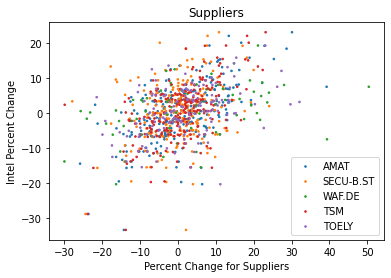

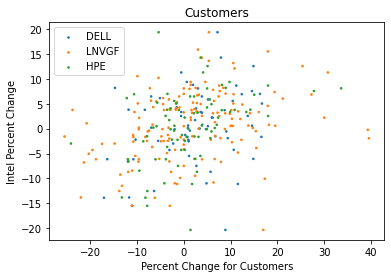

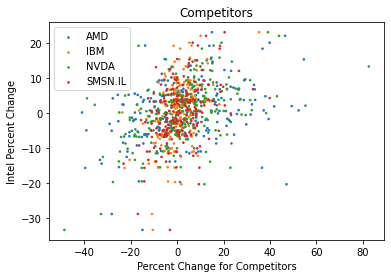

In [1261]:

def autoplot_intelpchange(compnames, name):


    # We are going to iterate through all the names, prepare a DF with the data we need to plot, turn it into a plot, and label it
    for n in compnames:
        toplot = prepare_plot(n)
        plt.scatter(x = toplot['percent_change_y'], y = toplot['percent_change_x'], label = n, s = [2.5 for a in toplot['percent_change_y']])

    # Setting all the names to be correct
    plt.ylabel("Intel Percent Change")
    plt.xlabel("Percent Change for " + name)
    plt.title(name)

    plt.legend()
    plt.show()


autoplot_intelpchange(suppliers, "Suppliers")

autoplot_intelpchange(customers, "Customers")

autoplot_intelpchange(competitors, "Competitors")


The above plots visually show the relationship between all the different companies' stock and company catergories' stock have on the change of price of Intel stock. Several trends are noticeable just be qualitatively looking at the graphs. Firstly, it appears, that as a whole, suppliers and Intel stock have the strongest correlation out of all three catergories of companies, customers and Intel have the weakest, and competitors is somewhere within between. 

Looking more into the plots, several interesting relationships between individual companies can be ascertained. Firstly, although competitors as a whole do not have a particularly strong relationships, if you were to look at the orange dots (IBM), and the red dots (SMSN.IL) and Intel stock, you will notice that there is a visually significantly stronger relationship between their stock than the other competitors. 

Furthermore, looking at the customer's graph, you will notice that although as a whole most companies do not have a strong relationship with Intel stock prices, HPE seems to have somewhat of a relationship, 

Finally, all the suppliers on the supplier's graph have a decently strong relationship with Intel stock prices, but TSM in particular is especially linearly clustered in comparison with the other stock relationships.

Now, we will analyze the change in commodity prices in relation to Intel stock prices.

In [1262]:
def prepare_plot_comm(commodity):

    # Gets just the columns we need to plot
    temp = commdata.drop(commdata.columns.difference(['Date'] + [commodity + '_PCHANGE']), 1)

    
    

    intdata = dfs['INTC']

    # Inner joining the two DFs
    merged = pd.merge(temp, intdata , on='Date')
    
    # Some of the commodity data has NaN values, so we're just going to remove
    merged.dropna(inplace=True)

    return merged.drop(columns='Date')

    


prepare_plot_comm('PBEVE')

,PBEVE_PCHANGE,percent_change
0,-4.766974,-3.325163
1,-0.142708,-33.394094
2,4.492992,2.397826
3,1.462563,-10.950850
4,11.220133,-15.664840
...,...,...
234,2.882470,-0.404860
235,2.155608,3.330658
236,-0.424908,-5.479190
237,1.302151,-2.214018


The above function is analagous to the prepare_plot() function written earlier, except it prepares commodity data for plotting. Now we can write the autoplotting function, and plot all the commodity prices:

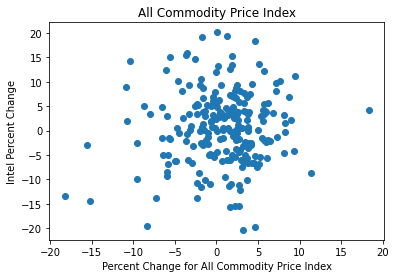

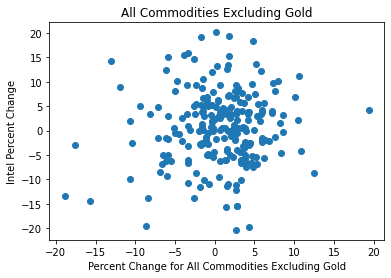

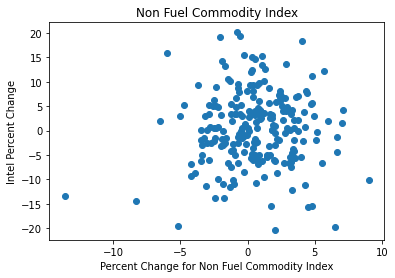

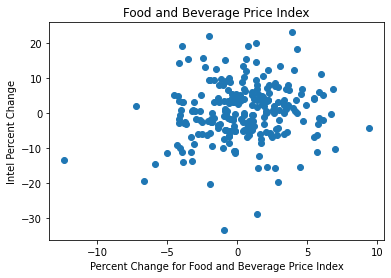

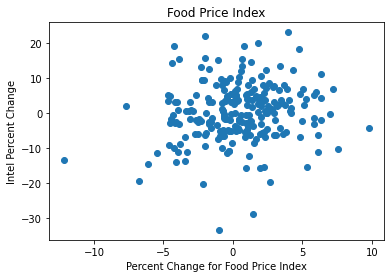

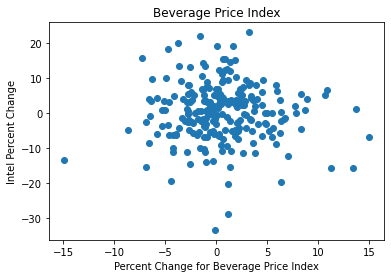

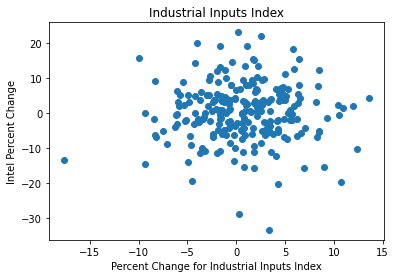

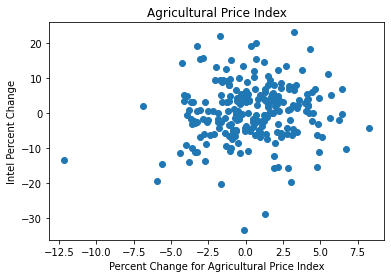

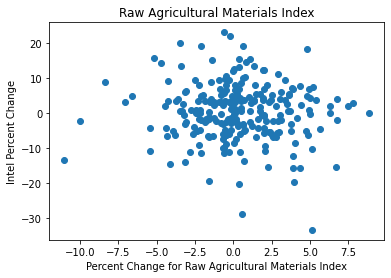

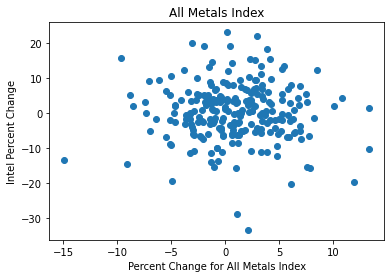

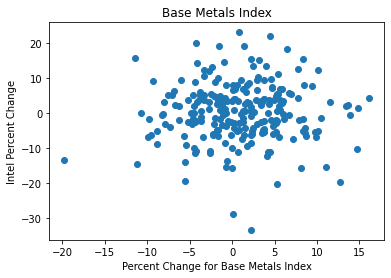

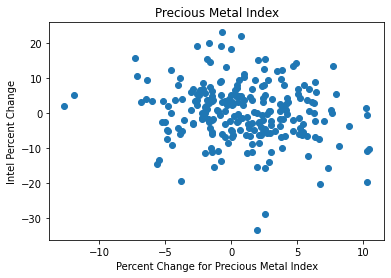

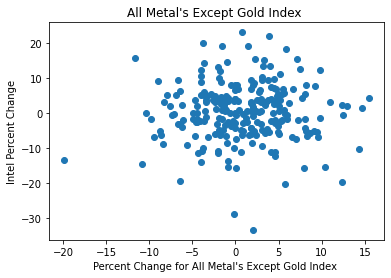

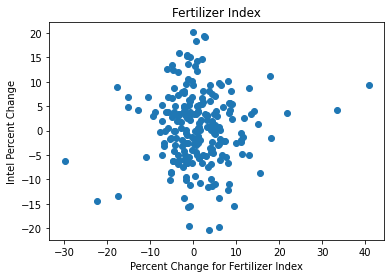

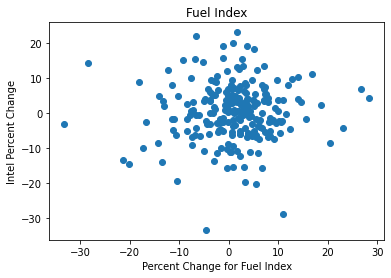

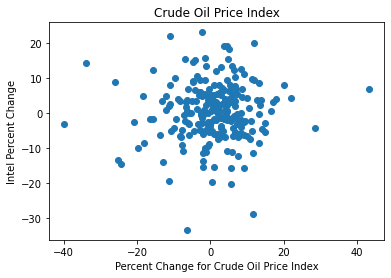

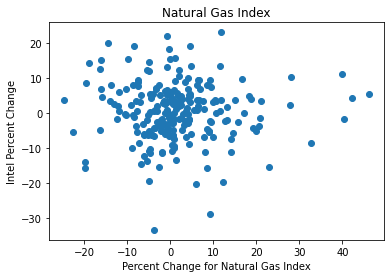

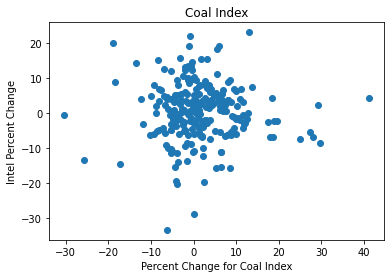

In [1263]:
def comm_autoplot_intelpchange(comm, name):

    
    # We are going to iterate through all the names, prepare a DF with the data we need to plot, turn it into a plot, and label it

    toplot = prepare_plot_comm(comm)
    plt.scatter(x = toplot[comm +  '_PCHANGE'], y = toplot['percent_change'])

    # Setting all the names to be correct
    plt.ylabel("Intel Percent Change")
    plt.xlabel("Percent Change for " + name)
    plt.title(name)

    
    plt.show()
    

for n in tpchange:
    # Plotting the commodity with the name from the dictionary
    comm_autoplot_intelpchange(n, namedict[n])
    

As shown by the plots above, the majority of the commodity price changes and Intel stock price changes show no significant relationship. However, there are a few interesting plots that are worth paying attention to nonethless. It is difficult to tell what relationships there are, since the data plots appear to be spread out without any distinct shapes, but a few that display a semblance for correlation are the fertilizer index, precious metal index, and the agricultural price index. Keep in mind that these relationships, if they even exist, would be exceptionally weak especially in comparison to the relationships we found with the stock price data earlier.

Firstly, the way that the fertilizer price index plot clusters is seemingly around a vertical line, much more tightly than the other commodity price indices. This would seem to indicate that whenever the fertilizer price index does not change, Intel stock price changes a lot.

Secondly, there is a slight, but noticeable negative linear relationship between precious metal commodity prices and Intel stock prices. This is unique among all the relationships we have seen so far in our tutorial, since all the other ones have been positive.

Thirdly, the agricultural price index seems to display a weak, but apparent positive linear relationship.


To recap, after plotting all the data with respect to Intel stock percent change, we have found that at least qualtatively, all of the supplier's company stocks have relatively strong positive linear relationships with Intel stock price. In addition, we have also found that SMSN.IL and TSM also both have strong relationships with Intel, but none of Intel's customers do. Finally, relative to other commodity price indices, Fertilizer, precious metals, and agriculture price indices have stronger relationships. The next phase of the data exploration is to determine the strength of their relationship.

In order to do this, we will fit a linear model, using statsmodels' OLS, and then print out a summary with OLS again giving us detailed statistics on the fit of the linear model, and related statistics describing the strength and significance of said model.

More information about Statsmodels OLS can be found here:
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

In [1264]:
# Fits a linear model and computes summary statistics on said model
def get_p_value(x, y):
    X = sm.add_constant(x)
    a = sm.OLS(y, X)
    b = a.fit()
    print(b.summary())


stocks_tofit = suppliers + ['TSM', 'SMSN.IL']
commodities_tofit = ['PAGRI', 'PFERT', 'PPMETA']


# Printing out stock data model statistics
for n in stocks_tofit:

    # Prepare plot also returns a dataframe formatted correctly for linear regression too
    temp = prepare_plot(n)

    # Have to switch around x and y since x is intel stock prices
    x = temp['percent_change_y']
    y = temp['percent_change_x']

    print(n)
    get_p_value(x, y)

# Printing out commodity data model statistics
for n in commodities_tofit:

    # Preparing the data for linear regression
    temp = prepare_plot_comm(n)

    x = temp[n +  '_PCHANGE']
    y = temp['percent_change']
    print(namedict[n])
    get_p_value(x, y)

AMAT
                            OLS Regression Results                            
Dep. Variable:       percent_change_x   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     131.1
Date:                Sun, 15 May 2022   Prob (F-statistic):           1.66e-24
Time:                        23:06:01   Log-Likelihood:                -800.06
No. Observations:                 242   AIC:                             1604.
Df Residuals:                     240   BIC:                             1611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1895      0.

While output from OLS is intimidating, we are mainly interested in two parameters for determing the statistical significance and strength of our linear correlation. The Prob (Jarque-Bera) parameter, and the R-squared parameter. R squared is the linear correlation coefficient squared. Quite simply, it tells us the strength of a linear relationship. The closer it is to one, the more closely two variables are linearly correlation. 

Jarque-Bera is a statistical test that measures how data approximates the normal distribution. Within regression analysis, it can tell us if there is a statistically significant relationship or not between two values. More information on it can be found at the link below:

https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test

Now, we will examine the output of all the tests. The R-squared statistics are rather low, with the greatest being 0.35. However, this does not mean that the data does not have any predictive power at all, and therefore should be ignored. The price of any stock is determined by numerous factors, and it is unlikely that any single factor will have much influence on the price of a stock. In our case, it appears that the company AMAT has the highest correlation with Intel stock prices, therefore has the highest predictive power.

Now, as for the JB test, notice that the company WAF.DE and the commidity index for fertilizer both have Prob(JB) > 0.05. Prob(JB) is the probability that the relationship we see is purely random, or in other words, not statistically significant. Therefore, they should be ignored, while the others have a Prob(JB) statistic of less than 0.05, meaning that their relationship is statistically significant.

## Hypothesis Testing


Now that we have explored our data, and found features that have a particularly strong relationship with Intel stock prices, we want to take the next step, and predict whether Intel's stock price will go up, or down, in a given month, for the hypothesis testing and ML part of the lifecycle. To do this, we will use a SkLearn's decision tree functionallity in order to create a supervised learning model, that based on the data features we found to be significant can classify the value of a target variable. More information on SkLearn's decision trees can be found below:

https://scikit-learn.org/stable/modules/tree.html

In order to set up the model, we need an independent and dependent data set. For our independent data set, we will need a bunch of data features. We will use the prices of stocks and commodities we found to be statistically significant for this. For our dependent data, we will use the Intel data converted converted into a dummy variable, 0 if the percent change is negative, 1 otherwise, which will allow the decision tree to classify whether the price for Intel stock is going up or down in any month. 

In [1265]:

# Commodities for our independent dataset
ml_comm = ['PAGRI', 'PPMETA']

stocks_tofit.remove('WAF.DE')
ml_stock = stocks_tofit


# + [commodity + '_PCHANGE']

# We will "Accumulate" an independent dataset through a series of inner joins
indaccum = commdata.drop(commdata.columns.difference(['Date'] ), 1)

# Accumulating the stock columns into the independent dataset
for n in ml_stock:
    indaccum = pd.merge(indaccum, dfs[n], on='Date')

# Accumulating the commodity columns into the dataset
for comm in ml_comm:
    indaccum = pd.merge(indaccum, commdata.drop(commdata.columns.difference(['Date'] + [comm + '_PCHANGE']), 1), on='Date')


intcdata_t = dfs['INTC']
intcdata = pd.DataFrame()


# Assigning a dummy variable to the percent change for intel stock
for i, row in intcdata_t.iterrows():
    if row['percent_change'] > 0:
        intcdata.at[i, 'change_intel'] = int(1)
        intcdata.at[i, 'Date'] = row['Date']
    else:
        intcdata.at[i, 'change_intel'] = int(0)
        intcdata.at[i, 'Date'] = row['Date']



# Creating a dependent dataset of the right size
temp = pd.merge(indaccum, intcdata, on='Date')

# Forcing to int (Pandas really wanted the 1s and 0s to be a float64 for some reaon)
intdep = pd.to_numeric(temp['change_intel'], downcast='integer')
dep = pd.Categorical.from_codes(intdep, ['down', 'up'])

indaccum.drop(columns=['Date'],  inplace=True)

dep

['down', 'down', 'up', 'down', 'up', ..., 'down', 'up', 'down', 'down', 'up']
Length: 129
Categories (2, object): ['down', 'up']

We now have our dependent dataset, and

In [1266]:
indaccum.head()

,percent_change_x,percent_change_y,percent_change_x,percent_change_y,percent_change_x,percent_change_y,PAGRI_PCHANGE,PPMETA_PCHANGE
0,4.716380,-4.761905,-5.967865,-3.299019,-5.967865,23.113916,4.244845,1.925156
1,-4.930006,1.554054,-0.895037,-13.440827,-0.895037,-4.553223,-0.782735,4.119931
2,0.448143,0.731870,10.837438,-2.452532,10.837438,5.079933,2.733644,4.669153
3,-12.173359,-11.492734,1.185185,0.921625,1.185185,1.506779,-3.463191,0.515255
4,-12.500000,-0.586265,2.377179,-0.193683,2.377179,0.000000,-1.256564,4.288786


our independent dataset. Now, we may move onto making the decision tree.

In [1267]:
dt = DecisionTreeClassifier()

# Computing cross validation scores for the decision tree
dt_scores =cross_val_score(dt, indaccum, dep, scoring='f1_macro', cv = 10)

print("DT Cross validation mean and st. dev:")
print("%0.2f accuracy with a standard deviation of %0.2f" % (dt_scores.mean(), dt_scores.std()))


print("The corresponding Z score and P value is")
ztest(dt_scores, value= 0.5)

DT Cross validation mean and st. dev:
0.61 accuracy with a standard deviation of 0.13
The corresponding Z score and P value is


(2.5673362450045754, 0.010248318203350535)

Note: Due to the inherent innaccurate randomness with the crossfold validation

Crossfold evaluation is a way of evaluating the performance of an estimator, or in our case, classifier. SkLearn provides us a handy method to do this given a model, independent, and dependent set. More information can be found at the link below:

https://scikit-learn.org/stable/modules/cross_validation.html

In our case, when fed the independent set with all the features, and the dependent set, our decision tree model was about 60% accurate, which is just about 10% more accurate than just guessing randomly if a stock will go up or down. Still, it is an improvement, and we can prove it, statistically.

Our null hypothesis is that our model is no better than guessing randomly, meaning it will have a 0.5 average accuracy. We want to show that it is better. One way to go about doing this is a Z test, more information at the link below:

https://en.wikipedia.org/wiki/Z-test

Statsmodels comes with a Z test function, seen above. According to the returned Z statistic and p value, we can see that there is, in fact, a statistically significant improvement over guessing randomly, even if it is small.

## Conclusion

Through our analysis of Intel stock data and other companies stock along with commodity prices, we found a few interesting trends, which we will talk about in the insight part of the data science lifecycle. Firstly, we found that the relationship with suppliers of Intel and Intel's stock prices is particularly strong, and also the relationship between TSM (Taiwan Semiconductor Manufacturing Company) and SMSN.IL (Samsung) is also particularly strong as well. Furthermore, we also found that there exists a slight negative relationship between the price of precious metals, and the price of Intel's stock. Finally, we also found that we can predict whether Intel's stock is going up or down, using a decision tree, at a slightly better but statistically significant improvement over just guessing randomly.

Overall, we can use the insights derived from this tutorial to inform budding traders about what factors make Intel stock go up and down, hopefully allowing them to turn a bit more profit than they otherwise would.

We could further expand our analysis by throwing even more data and seeing what improves the accuracy of our model. For example, we could scrape social media and news sites and process it with NLP in ordet to determine public sentiment of Intel, thereby adding another feature to our independent dataset. We could also find more specific commodity data, such as silicon prices or other market indicators.